In [3]:
# 1. Khai báo thư viện

# Hệ thống và thao tác tệp
import os
import pathlib
from google.colab import files

# Xử lý dữ liệu
import numpy as np
import pandas as pd

# Hiển thị và đánh giá, thống kê
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Thư viện học sâu
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing import image_dataset_from_directory
from keras.applications.resnet50 import preprocess_input

In [9]:
# 2. Tiền xử lý dữ liệu

# 2.1. Khai báo đường dẫn
data_dir = "/content/drive/MyDrive/car-data2/car-data2/train"
data_dir = pathlib.Path(data_dir)
print(data_dir)

# 2.2. Chuẩn hoá dữ liệu, tách dataset
img_height, img_width = 224, 224
batch_size = 16

# Tách tập train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir, validation_split = 0.2, subset="training", seed=123, image_size=(img_height,img_width),batch_size=batch_size)

# Tách tập validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset="validation", seed=123, image_size=(img_height,img_width), batch_size=batch_size)

# 2.3 Chuẩn hoá ảnh theo yêu cầu của mô hình resnet50
autotune = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=autotune)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=autotune)

/content/drive/MyDrive/car-data2/car-data2/train
Found 5071 files belonging to 15 classes.
Using 4057 files for training.
Found 5071 files belonging to 15 classes.
Using 1014 files for validation.


In [10]:
# 3. Khởi tạo mô hình

# 3.1. Các bước khởi tạo ban đầu
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False, input_shape=(224,224,3), weights='imagenet', pooling='avg')
pretrained_model.trainable = False # Đóng băng resnet
resnet_model.add(pretrained_model) # Thêm pretrained resnet

# 3.2. Thêm các lớp cho mô hình
# Thêm Flatten layer để chuyển đổi dữ liệu từ ma trận 2D thành vector 1D
resnet_model.add(layers.Flatten())

# Thêm các lớp Dense với L2 regularization và Dropout
resnet_model.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
resnet_model.add(layers.Dropout(0.2))
resnet_model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

# Thêm một Dense layer nữa với BatchNormalization
resnet_model.add(layers.Dense(64))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Activation('relu'))

# Lớp đầu ra với softmax
resnet_model.add(layers.Dense(15, activation='softmax'))

# 3.3. Kiểm tra tổng quát mô hình
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,675,023 (94.13 MB)

 Trainable params: 1,087,183 (4.15 MB)

 Non-trainable params: 23,587,840 (89.98 MB)

In [11]:
# 4. Huấn luyên mô hình

# 4.1. Biên dịch mô hình
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# 4.2. Tạo callback để tính f1_score
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data  # Truyền val_ds vào đây

    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_labels = []

        for batch in self.val_data:
            images, labels = batch
            preds = self.model.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)
            val_preds.extend(preds)
            val_labels.extend(labels.numpy())

        f1 = f1_score(val_labels, val_preds, average='macro')
        print(f"\nEpoch {epoch + 1} — val_f1_score: {f1:.4f}")

In [13]:
# 4.3. Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4.4. Huấn luyện kèm callback
f1_callback = F1ScoreCallback(val_data=val_ds)
history = resnet_model.fit(
    train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping, f1_callback])

Epoch 1/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2092 - loss: 3.4192
Epoch 1 — val_f1_score: 0.4662
254/254 ━━━━━━━━━━━━━━━━━━━━ 966s 4s/step - accuracy: 0.2097 - loss: 3.4178 - val_accuracy: 0.5592 - val_loss: 2.4350
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5970 - loss: 2.3746
Epoch 2 — val_f1_score: 0.5899
254/254 ━━━━━━━━━━━━━━━━━━━━ 58s 229ms/step - accuracy: 0.5971 - loss: 2.3742 - val_accuracy: 0.6992 - val_loss: 1.9825
Epoch 3/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7260 - loss: 1.9649
Epoch 3 — val_f1_score: 0.7090
254/254 ━━━━━━━━━━━━━━━━━━━━ 60s 234ms/step - accuracy: 0.7261 - loss: 1.9645 - val_accuracy: 0.7781 - val_loss: 1.7252
Epoch 4/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8022 - loss: 1.7123
Epoch 4 — val_f1_score: 0.7747
254/254 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.8022 - loss: 1.7121 - val_accuracy: 0.8245 - val_loss: 1.5644
Epoch 5/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/

In [14]:
# 4.5. Lưu các file về máy
import pickle

resnet_model.save('Model.h5')
files.download('Model.h5')

with open('History.pkl', 'wb') as f:
    pickle.dump(history.history, f)
files.download('History.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

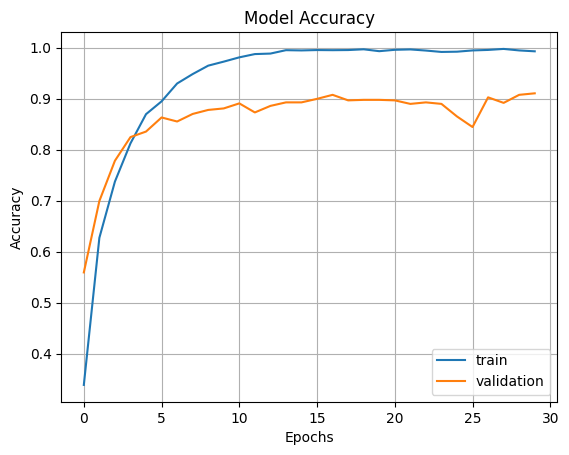

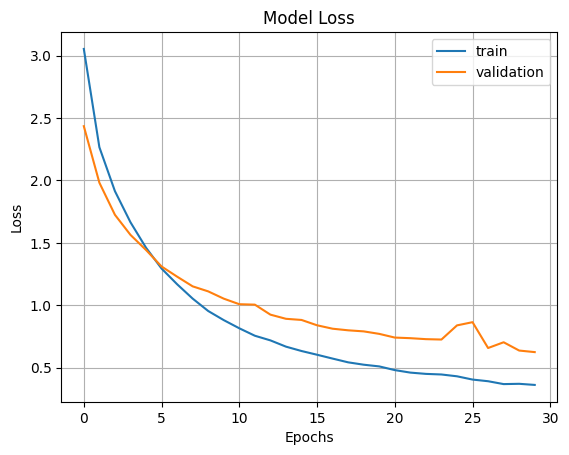

In [15]:
# 5. Đánh giá mô hình

# 5.1. Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

# 5.2. Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

In [4]:
# 6. Kiểm thử mô hình

# 6.1. Tải mô hình lên
model_path = "/content/drive/MyDrive/model_15class_1505/Model.h5"
model = keras.models.load_model(model_path)

# 6.2. Hàm tiền xử lý ảnh test
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).resize(target_size) # Mở ảnh và resize
    img_array = np.array(img) # Chuyển ảnh sang mảng numpy
    img_array = np.expand_dims(img_array, axis=0) # Thêm batch dimension
    img_array = preprocess_input(img_array) # Tiền xử lý theo chuẩn ResNet50
    return img_array

# 6.3. Tải ảnh test lên
image_path = '/content/drive/MyDrive/car-data2/car-data2/test/Ford_Ranger/000014.jpg'
processed_img = preprocess_image(image_path)

# 6.4. Dự đoán
predictions = model.predict(processed_img, verbose=0)
predicted_class = np.argmax(predictions)
confidence = 100 * np.max(predictions)

# class_names = ['Audi', 'BMW X6', 'Ford Ranger', 'Kia K2', 'Huyndai Creta', 'Mahindra Scorpio',
#                'Mercedes E300', 'Mitsubishi Xpander', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']

class_names = ['Audi', 'Ford_Ranger', 'Honda_City (293)',
               'Hyundai Creta', 'Mahindra Scorpio', 'Mazda_3 (397)',
               'Mitsubishi_Xpander (325)', 'Rolls Royce', 'Swift',
               'Tata Safari', 'Toyota Innova', 'Toyota_Camry (283)',
               'VinFast_Fadil (365)', 'bmw x6 (227)', 'kia k2 (300)']

print(f"Hình ảnh giống với dòng xe: {class_names[predicted_class]}, độ tin cậy: {confidence:.2f}%")
# print("Hình ảnh giống với dòng xe: {}, độ tin cậy: {:.2f}%".format(class_names[predicted_class], confidence))
# print("Hình ảnh giống với dòng xe: ", class_names[predicted_class], ", độ tin cậy: ", round(confidence, 2), "%")

Hình ảnh giống với dòng xe: Ford_Ranger, độ tin cậy: 84.05%


Found 1665 files belonging to 15 classes.


105/105 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step

Classification Report:

                          precision    recall  f1-score   support

                    Audi       0.87      0.97      0.92       199
             Ford_Ranger       0.97      0.98      0.97       130
        Honda_City (293)       0.65      0.78      0.71        93
           Hyundai Creta       0.80      0.85      0.83        67
        Mahindra Scorpio       0.96      0.93      0.95        75
           Mazda_3 (397)       0.95      0.89      0.92       133
Mitsubishi_Xpander (325)       0.84      0.88      0.86       109
             Rolls Royce       0.95      0.78      0.86        74
                   Swift       0.95      0.89      0.92       102
             Tata Safari       0.96      0.95      0.96       106
           Toyota Innova       0.95      0.95      0.95       190
      Toyota_Camry (283)       0.79      0.88      0.83        89
     VinFast_Fadil (365)       0.96      0.91      0.93       122
        

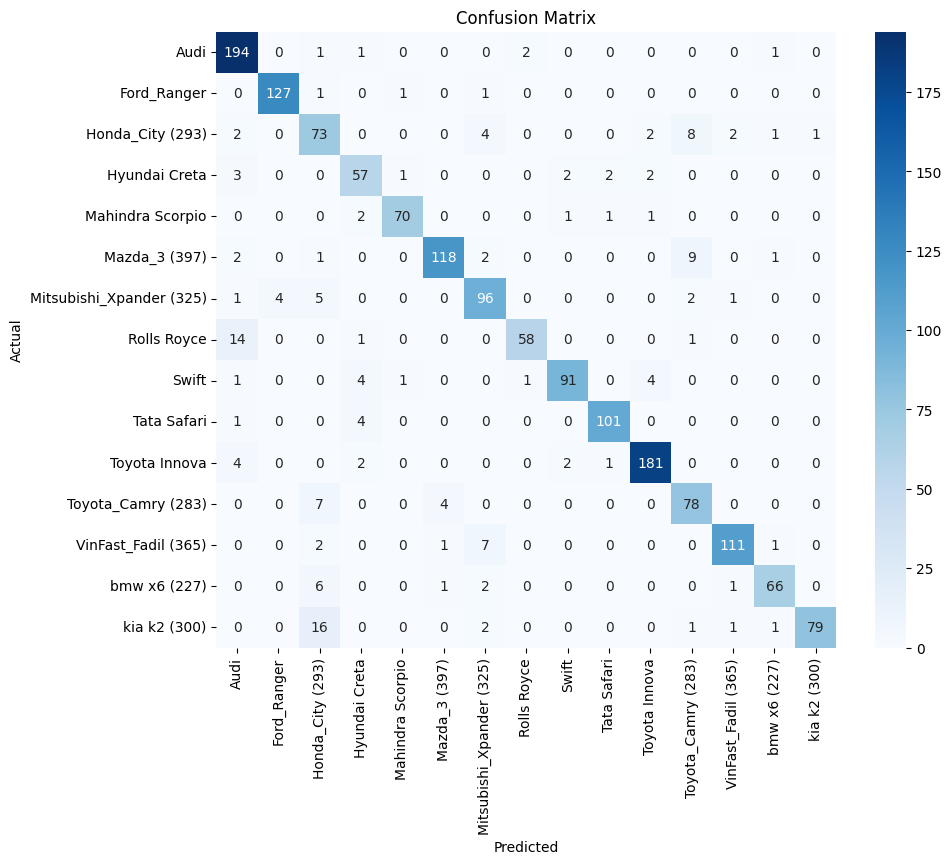

In [5]:
# 7. Nhận diện tập ảnh test
# Parameters
img_height, img_width = 224, 224
batch_size = 16
test_dir = "/content/drive/MyDrive/car-data2/car-data2/test"

# Load test dataset
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Không shuffle để so sánh y_true vs y_pred dễ
)
class_names = test_ds.class_names

# Apply ResNet50 preprocessing
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/model_15class_1505/Model.h5")

# Predict
y_pred_logits = model.predict(test_ds)
y_pred = np.argmax(y_pred_logits, axis=1)

# Ground-truth labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Evaluation report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()